In [67]:
from matplotlib import pyplot as plt
import numpy as np
import analysisFunctions as aF
from scipy.signal import find_peaks, correlate
from scipy.ndimage import gaussian_filter, median_filter
from scipy.stats import sem
import seaborn as sns
import seaborn_image as isns
import cmcrameri.cm as cmc
from signal_analysis import SignalAnalysis


cmap = 'cmc.batlow'
sns.set_palette(cmap)

## Opening and sorting data

In [68]:
pathBase = r"C:\Users\gabri\Desktop\testAnalyse"

violet = np.loadtxt(pathBase + "\\csv\\405.csv", skiprows=1, delimiter=',')
violet = violet[:,1]
blue = np.loadtxt(pathBase + "\\csv\\470.csv", skiprows=1, delimiter=',')
blue = blue[:,1]
green = np.loadtxt(pathBase + "\\csv\\530.csv", skiprows=1, delimiter=',')
green = green[:,1]
red = np.loadtxt(pathBase + "\\csv\\625.csv", skiprows=1, delimiter=',')
red = red[:,1]
LSCI = np.loadtxt(r"C:\Users\gabri\Desktop\testAnalyse\07-18\785std.csv", delimiter=',', skiprows=1)
LSCI = LSCI[:,1]

violet_t = np.load(pathBase + "\\405ts.npy")
blue_t = np.load(pathBase + "\\470ts.npy")
green_t = np.load(pathBase + "\\530ts.npy")
red_t = np.load(pathBase + "\\625ts.npy")
LSCI_t = np.load(r"C:\Users\gabri\Desktop\testAnalyse\07-18\785ts.npy")
LSCI_t = LSCI_t[:-1]

# np.savetxt(pathBase+'\\blue_t.txt', blue_t)       # debugging timestamps



## Plotting raw data

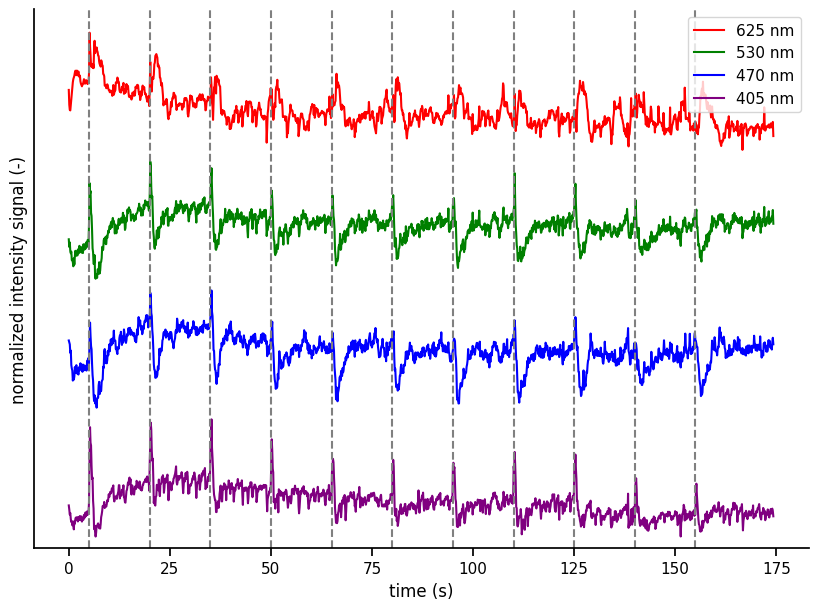

In [69]:
sns.set_context('notebook')

violet = aF.normalizeData(violet, dim=1)
blue = aF.normalizeData(blue, dim=1)
green = aF.normalizeData(green, dim=1)
red = aF.normalizeData(red, dim=1)
LSCI = aF.normalizeData(LSCI, dim=1) *-1 + 1

## AP approx
ncycles = 11
AP = np.array(list(range(ncycles))) * 15 + 5

fig = plt.figure(figsize=(10, 7))
plt.plot(red_t, red+3.3, color='red', label='625 nm')
plt.plot(green_t, green+2.2, color='green', label='530 nm')
plt.plot(blue_t, blue+1.1, color='blue', label='470 nm')
plt.plot(violet_t, violet, color='purple', label='405 nm')

plt.vlines(AP, -0.1, 4.5, color='grey', linestyles='--')


plt.legend()
plt.ylim(-0.1, 4.5)
# plt.xlim(0, 80)
plt.xlabel("time (s)")
plt.ylabel("normalized intensity signal (-)")
ax = plt.gca()
ax.set_yticklabels([])
ax.set_yticks([])
sns.despine()

# plt.savefig("raw_signal_zoom.png", dpi=600)



## Data aligned on air puffs

The lag is 0.24 s


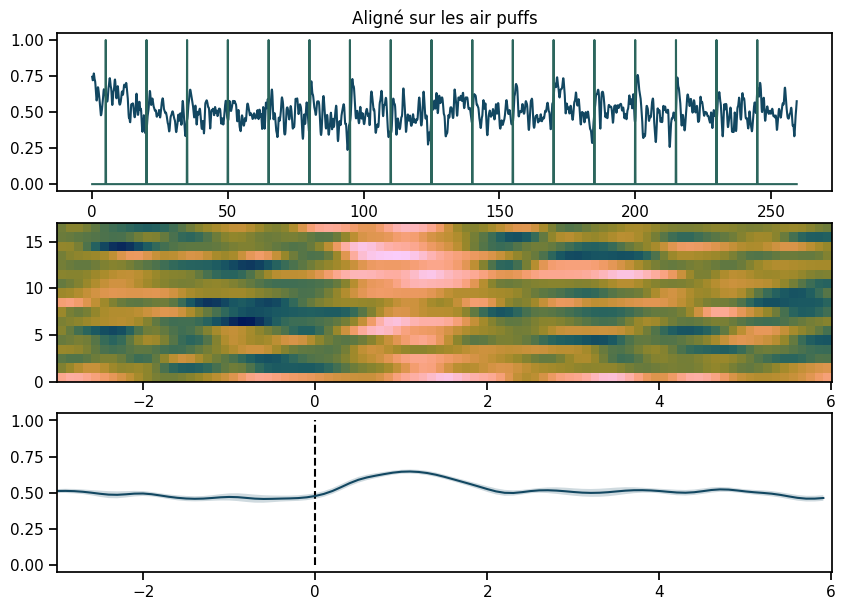

In [70]:
FPS = 40

# time, sig = (violet_t, violet)
# time, sig = (blue_t, blue)
# time, sig = (green_t, green)
# time, sig = (red_t, red)
time, sig, FPS = (LSCI_t, gaussian_filter(LSCI, sigma=2), 50)


AP_idx = []
nChannels=5
AP_begin = 5
percycle=15
FPSc = FPS/nChannels
framespcycles = int(FPSc*percycle)
ncycles = int(len(time)//framespcycles)
AP_times = np.array(list(range(ncycles)))*15+5

for ti in AP_times:
    AP_idx.append(np.argmin(np.absolute(time-ti)))

# Dirac où AP dans times series
AP_series = np.zeros(len(time))
AP_series[AP_idx] = 1

fig = plt.figure(figsize=(10, 7))
ax1 = plt.subplot(3, 1, 1)
plt.title('Aligné sur les air puffs')
ax1.plot(time, sig)
ax1.plot(time, AP_series)
# ax1.set_xlim(0, 40)

inf = 30
sup = 60
aligned_data = np.zeros((len(AP_idx), inf+sup))
for i in range(len(AP_idx)):
  aligned_data[i,:] = sig[int(AP_idx[i]-inf):int(AP_idx[i]+sup)]
ax2 = plt.subplot(3, 1, 2)
ax2.imshow(aligned_data, origin='lower', extent=[time[AP_idx[0]-inf]-time[AP_idx[0]], time[AP_idx[0]+sup]-time[AP_idx[0]], 0, ncycles], aspect='auto', cmap=cmap)

avg_data = np.mean(aligned_data, axis=0)
# std_data = np.std(aligned_data, axis=0)
std_data = sem(aligned_data, axis=0)
ax3 = plt.subplot(3, 1, 3)
ax3.vlines(0, 0, 1, color='k', linestyles='--')
ax3.plot(time[AP_idx[0]-inf:AP_idx[0]+sup]-time[AP_idx[0]], avg_data)
ax3.fill_between(time[AP_idx[0]-inf:AP_idx[0]+sup]-time[AP_idx[0]], avg_data-std_data, avg_data+std_data, alpha=0.2)
ax3.set_xlim(time[AP_idx[0]-inf]-time[AP_idx[0]], time[AP_idx[0]+sup]-time[AP_idx[0]])

correlation = correlate(AP_series, sig)
lag = np.argmax(correlation)
print('The lag is', (len(time)-lag)/FPS, 's')
# plt.plot(correlation)

plt.show()



## 4 signaux alignés moyennés sur AP

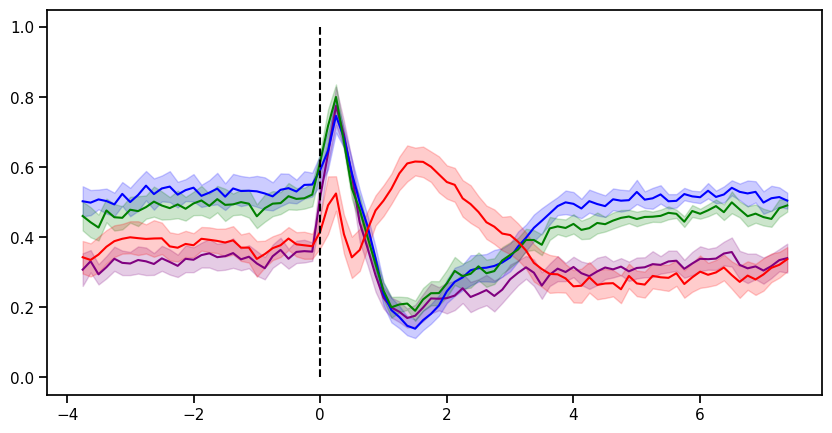

In [71]:
times = (violet_t, blue_t, green_t, red_t)
sigs = (violet, blue, green, red)
cols = ('purple', 'blue', 'green', 'red')

inf = 30
sup = 60

avg_data = np.mean(aligned_data, axis=0)
std_data = sem(aligned_data, axis=0)

fig = plt.figure(figsize=(10, 5))

for time, sig, col in zip(times, sigs, cols):
  # AP
  AP_idx = []
  nChannels=5
  AP_begin = 5
  percycle=15
  FPSc = FPS/nChannels
  framespcycles = int(FPSc*percycle)
  ncycles = int(len(time)//framespcycles)
  AP_times = np.array(list(range(ncycles)))*15+5
  for ti in AP_times:
      AP_idx.append(np.argmin(np.absolute(time-ti)))
  # Data
  aligned_data = np.zeros((len(AP_idx), inf+sup))
  for i in range(len(AP_idx)):
    aligned_data[i,:] = sig[int(AP_idx[i]-inf):int(AP_idx[i]+sup)]
  avg_data = np.mean(aligned_data, axis=0)
  std_data = sem(aligned_data, axis=0)
  plt.plot(time[AP_idx[0]-inf:AP_idx[0]+sup]-time[AP_idx[0]], avg_data, color=col)
  plt.fill_between(time[AP_idx[0]-inf:AP_idx[0]+sup]-time[AP_idx[0]], avg_data-std_data, avg_data+std_data, alpha=0.2, color=col)

plt.vlines(0, 0, 1, color='k', linestyles='--')
plt.show()